# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

## Некоторые промежуточный функции

In [2]:
# def subtotals(x):
#     X = sorted(list(set(x)))
# #     print(X)
#     res = np.zeros(len(X)-1)
#     for i in range(len(X) - 1):
#         res[i] = (X[i] + X[i+1])/2
#     return res

def subtotals(x):
    X = np.array(sorted(list(set(x))))
    
    return (X[1:] + X[:-1])/2

st = [1,2,10,10,10,10,10,3,4,5,6,7,7,7,7,7]
res = subtotals(st)
print(f'Вход: {st}')
print(f'Выход: {res}')

Вход: [1, 2, 10, 10, 10, 10, 10, 3, 4, 5, 6, 7, 7, 7, 7, 7]
Выход: [1.5 2.5 3.5 4.5 5.5 6.5 8.5]


## Задание 1 (1 балл)

Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [72]:
def gini(x):
    labels = list(set(x.flatten()))
    n = len(x)
    m = len(labels)
    Y = dict()
    for i in range(max(labels) + 1):
        Y[i] = 0
    
    for label in x:
#         print(label, type(label), type(x))
        Y[label] += 1/n
        
    S = 0
    for key in Y.keys():
        S += Y[key]*(1 - Y[key])
    
    return S
    
def entropy(x):
    labels = list(set(x.flatten()))
    n = len(x)
    m = len(labels)
    Y = dict()
    for i in range(max(labels) + 1):
        Y[i] = 0
    
    for label in x:
        Y[label] += 1/n
        
    S = 0
    for key in Y.keys():
        if Y[key] != 0:
            S -= Y[key]*np.log2(Y[key])
        
    return S

def gain(left_y, right_y, criterion):
    y = np.append(left_y, right_y)
    n_left = len(left_y)
    n_right = len(right_y)
    n_all = n_left + n_right
    return (n_all*criterion(y) - n_right*criterion(right_y) - n_left*criterion(left_y))/n_all

test = np.random.choice(5, 100)
test2 = np.random.choice(5, 100)
# (test)
print(test)
print(test2)
print(gain(test,test2, gini))

[2 0 1 0 2 4 4 4 4 1 0 2 3 1 4 2 1 3 2 0 0 0 1 3 4 2 1 2 1 4 0 1 0 0 0 1 3
 1 1 3 0 3 1 3 0 0 2 2 1 4 2 2 3 1 1 4 4 2 1 1 1 2 4 4 0 1 0 3 2 2 0 1 3 3
 1 4 2 1 0 2 2 0 2 1 1 0 3 4 2 1 2 0 0 4 2 2 1 1 2 4]
[4 2 3 1 2 4 3 3 0 0 1 4 1 1 4 3 3 1 4 2 4 3 0 0 0 1 0 4 3 0 1 4 4 0 0 0 3
 1 1 2 4 3 2 0 0 3 3 0 3 3 2 2 3 0 4 0 0 2 1 2 2 2 1 2 0 0 2 2 4 0 3 1 0 3
 2 0 1 3 1 2 2 1 2 3 4 2 3 3 1 1 1 4 2 3 2 3 1 1 0 0]
0.004150000000000134


## Задание 2 (1 балл)

Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [5]:
class DecisionTreeLeaf:
    def __init__(self, y):
        self.y = y
        self.N = len(y)
        self.set = list(set(y.flatten()))
#         raise NotImplementedError()

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right
#         raise NotImplementedError()

## Задание 3 (6 баллов)

Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [69]:
class DecisionTreeClassifier:

    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_rec = 0

        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        else:
            raise NotImplementedError()

    def build(self, X, y, cur_rec, max_IG, side):

        if cur_rec > self.max_rec:
            self.max_rec = cur_rec

        key2 = False
        max_IG = -np.inf
        res_column = 0
        res_threshold = -np.inf

        columns = np.arange(X.shape[1])

        for column in columns:
            X_temp = X[:, column]

            thresholds = subtotals(X_temp)

            #             if len(X_temp) > 300:
            #                 thresholds = subtotals(X_temp)
            #             else:
            #                 thresholds = np.array(sorted(list(set(X_temp))))

            #             print(len(thresholds), len(set(X_temp)),cur_rec, X_temp.shape, X.shape)

            for threshold in thresholds:
                left = y[X_temp < threshold]
                right = y[X_temp >= threshold]

                #                 print(cur_rec, left.shape, right.shape, len(left))

                if len(left) < self.min_samples_leaf or len(
                        right) < self.min_samples_leaf:
                    #                     print(cur_rec, left.shape, right.shape, len(left))
                    continue

#                 print(left.reshape(len(left),).shape, right.shape)
                IG = gain(left.reshape(len(left), ),
                          right.reshape(len(right), ), self.criterion)

                if IG > max_IG:
                    key2 = True
                    res_column = column
                    max_IG = IG
                    res_threshold = threshold

#         print(cur_rec, res_column, X.shape, res_threshold)
        yl = y[X[:, res_column] < res_threshold]
        yr = y[X[:, res_column] >= res_threshold]

        Xl = np.delete(X[X[:, res_column] < res_threshold], res_column, axis=1)
        Xr = np.delete(X[X[:, res_column] >= res_threshold],
                       res_column,
                       axis=1)

        key = False
        if self.max_depth is None:
            key = False
        elif self.max_depth <= cur_rec:
            key = True
#         if X.shape[1] <= 1 or X.shape[0] == 0 or res_threshold == np.inf:
        if res_threshold == np.inf or Xl.shape[1] == 0 or Xr.shape[1] == 0:
            #             print(X.shape, X)
            key = True

#         print(cur_rec, key, key2, side,Xl.shape, Xr.shape, res_threshold,gain(left.reshape(len(left), ),
#                           right.reshape(len(right), ), self.criterion))
        if key or not key2:
            return DecisionTreeLeaf(y)
        else:
            #             print(cur_rec, Xl.shape, Xr.shape, yl.shape, yr.shape, res_threshold, max_IG, key)
            return DecisionTreeNode(res_column, res_threshold,
                                    self.build(Xl, yl, cur_rec + 1, max_IG, 'left'),
                                    self.build(Xr, yr, cur_rec + 1, max_IG, 'right'))

    def search(self, x, Node):
        if type(Node) is DecisionTreeLeaf:
            res = dict()
            for key in Node.set:
                res[key] = np.sum(Node.y == key) / Node.N


#                 print(res[key], np.sum(Node.y == key), Node.N)
#             print(res)
            return res

        elif type(Node) is DecisionTreeNode:

            if x[Node.split_dim] < Node.split_value:
                return self.search(x, Node.left)
            elif x[Node.split_dim] >= Node.split_value:
                return self.search(x, Node.right)
            else:
                raise NotImplementedError()

        else:
            raise NotImplementedError()

    def fit(self, X, y):
        self.root = self.build(X, y, 1, -np.inf, 'None')

    def predict_proba(self, X):
        pred = []
        N = len(X)
        for i in range(N):
            pred += [self.search(X[i], self.root)]
        return pred

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.array([max(p.keys(), key=lambda k: p[k]) for p in proba])

In [70]:
def sample(N):
    y1 = np.bool_(np.random.choice(2, N, replace=True))
    y2 = np.logical_not(y1)
    return y1,y2
test = np.arange(10)
i1,i2 = sample(10)
test[i1]

array([0, 1, 2, 7])

Для коэф-та: 0.5, макс-ой глубины: 5 и мин-го листа: 30 метрики равны:
Accuracy = 0.857
Recall = 0.699
Precision = 0.922
F1-score = 0.795


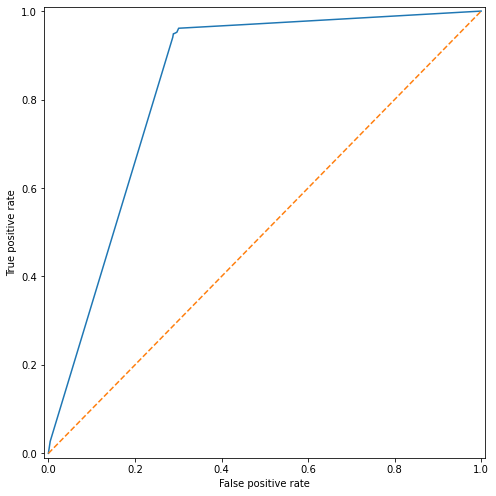

In [78]:
coef = 0.5

df_X = pd.read_csv('x_spam_train.csv').drop('Id', axis=1)
df_y = pd.read_csv('y_spam_train.csv').drop('Id', axis=1)

N = round(len(df_X)*coef)
X = np.array(df_X.iloc[:N])
y = np.array(df_y.iloc[:N])

X_test = np.array(df_X.iloc[N:])
y_test = np.array(df_y.iloc[N:]).reshape(len(X_test),)

tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, criterion='gini')
tree.fit(X, y)

y_pred = tree.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Для коэф-та: {coef}, макс-ой глубины: {5} и мин-го листа: {30} метрики равны:')
print(f'Accuracy = {acc:.3f}')
print(f'Recall = {recall:.3f}')
print(f'Precision = {precision:.3f}')
print(f'F1-score = {f1:.3f}')
# print(tree.max_rec)

plot_roc_curve(y_test, tree.predict_proba(X_test))
# draw_tree(tree, 'test.png')

In [64]:
def AUC(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(
            sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) /
            positive_samples)
        fpr.append(
            sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) /
            (len(y_test) - positive_samples))
    return np.dot(tpr, fpr)

45.536062481267955

In [66]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from tqdm import tqdm
depths = [None, 2, 3, 5]
coefs = [0.3, 0.5, 0.7]
min_leafs = [5, 15, 30]
crits = ['gini', 'entropy']

df = pd.DataFrame(columns=['Min_leafs','Depth','Coef','Accuracy','Recall','Precision','F1', 'AUC'])

df_X = pd.read_csv('x_spam_train.csv').drop('Id', axis=1)
df_y = pd.read_csv('y_spam_train.csv').drop('Id', axis=1)

for coef in coefs:
    for crit in crits:
        for depth in depths:
            for leaf in min_leafs:
                N = round(len(df_X)*coef)

                X = np.array(df_X.iloc[:N])
                y = np.array(df_y.iloc[:N])

                X_test = np.array(df_X.iloc[N:])
                y_test = np.array(df_y.iloc[N:]).reshape(len(X_test),)

                tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf, criterion=crit)
                tree.fit(X, y)
                y_pred = tree.predict(X_test)

                acc = accuracy_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)
                print(f'Коэф-т: {coef}, критерий: {crit}, глубина:{depth}, листья:{leaf}')
                #             print(f'Для коэф-та: {coef}, макс-ой глубины: {depth} и мин-го листа: {leaf} метрики равны:')
                #             print(f'Accuracy = {acc:.3f}')
                #             print(f'Recall = {recall:.3f}')
                #             print(f'Precision = {precision:.3f}')
                #             print(f'F1-score = {f1:.3f}')
                #             print('')

                d = {
                    'Min_leafs':leaf,
                    'Depth':depth,
                    'crit':crit,
                    'Coef':coef,
                    'Accuracy':acc,
                    'Recall':recall,
                    'Precision':precision,
                    'F1':f1,
                    'AUC':AUC(y_test, tree.predict_proba(X_test))
                }

            df = df.append(d, ignore_index=True)
df

Коэф-т: 0.3, критерий: gini, глубина:None, листья:5
Коэф-т: 0.3, критерий: gini, глубина:None, листья:15
Коэф-т: 0.3, критерий: gini, глубина:None, листья:30
Коэф-т: 0.3, критерий: gini, глубина:2, листья:5
Коэф-т: 0.3, критерий: gini, глубина:2, листья:15
Коэф-т: 0.3, критерий: gini, глубина:2, листья:30
Коэф-т: 0.3, критерий: gini, глубина:3, листья:5
Коэф-т: 0.3, критерий: gini, глубина:3, листья:15
Коэф-т: 0.3, критерий: gini, глубина:3, листья:30
Коэф-т: 0.3, критерий: gini, глубина:5, листья:5
Коэф-т: 0.3, критерий: gini, глубина:5, листья:15
Коэф-т: 0.3, критерий: gini, глубина:5, листья:30
Коэф-т: 0.3, критерий: entropy, глубина:None, листья:5
Коэф-т: 0.3, критерий: entropy, глубина:None, листья:15
Коэф-т: 0.3, критерий: entropy, глубина:None, листья:30
Коэф-т: 0.3, критерий: entropy, глубина:2, листья:5
Коэф-т: 0.3, критерий: entropy, глубина:2, листья:15
Коэф-т: 0.3, критерий: entropy, глубина:2, листья:30
Коэф-т: 0.3, критерий: entropy, глубина:3, листья:5
Коэф-т: 0.3, крите

KeyboardInterrupt: 

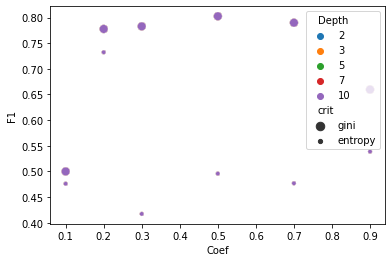

In [267]:
sns.scatterplot(data=df, x='Coef', y='F1', hue='Depth', size='crit')
df.to_csv('HyperParameters3.csv')

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [24]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
#     plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
#     plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [25]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Задание 4 (2 балла)

Протестируйте решение на датасете spam.
Для этой задачи используйте данные x_spam_train и y_spam_train:
1. Выполните загрузку и предобработку файлов x_spam_train и y_spam_train.
2. Разбейте x_spam_train и y_spam_train на x_train, y_train, x_test и y_test для оценки точности работы алгоритма.
3. Посчитайте метрики `precision`, `recall`, `accuracy` для модели Decision Tree. Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.
4. Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`).
5. Ответьте на следующие вопросы:
    - Какой нужен препроцессинг данных для моделей?
    - Какая модель делает предсказания лучше?  Предположите, почему.

_Ваш ответ_

In [26]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.neighbors import KNeighborsClassifier

Для коэф-та: 0.3, макс-ой глубины: 5 и мин-го листа: 30 метрики равны:
Accuracy = 0.834
Recall = 0.641
Precision = 0.915
F1-score = 0.754



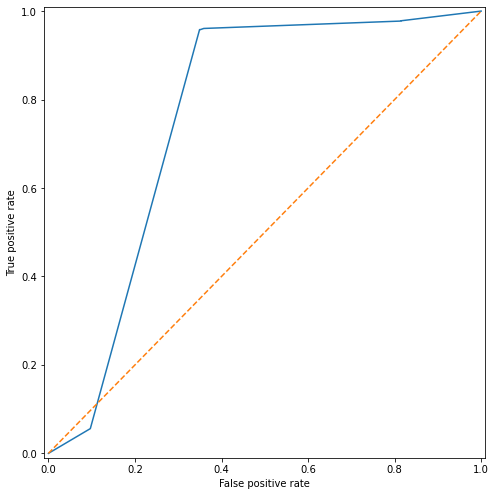

In [33]:
coef = 0.3

df_X = pd.read_csv('x_spam_train.csv').drop('Id', axis=1)
df_y = pd.read_csv('y_spam_train.csv').drop('Id', axis=1)

N = round(len(df_X)*coef)
X = np.array(df_X.iloc[:N])
y = np.array(df_y.iloc[:N])

X_test = np.array(df_X.iloc[N:])
y_test = np.array(df_y.iloc[N:]).reshape(len(X_test),)

tree = DecisionTreeClassifier(max_depth=7, min_samples_leaf=1)
tree.fit(X, y)

y_pred = tree.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Для коэф-та: {coef}, макс-ой глубины: {5} и мин-го листа: {30} метрики равны:')
print(f'Accuracy = {acc:.3f}')
print(f'Recall = {recall:.3f}')
print(f'Precision = {precision:.3f}')
print(f'F1-score = {f1:.3f}')
print('')

plot_roc_curve(y_test, tree.predict_proba(X_test))
# draw_tree(tree)

1. Обучите модель на всех данных из x_spam_train и y_spam_train.
2. Сделайте submit своего решения и получите значение f1_score не менее 0.6

In [ ]:
submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = test["Id"]
submission["Expected"] = #YOUR CODE
submission.to_csv('submission.csv', index=False)
